mu: 0.005383621617717364
mse: 0.0008333437069053837


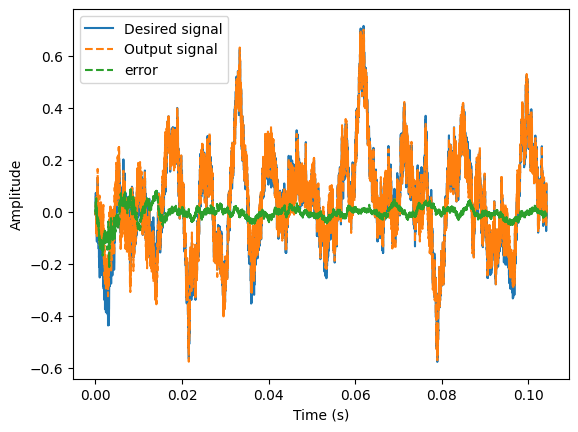

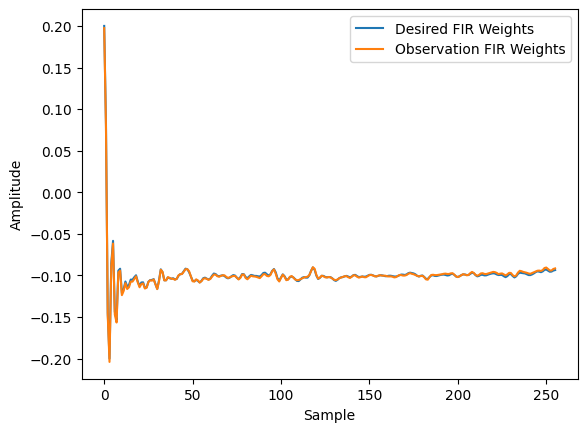

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import freqz, welch
from Signal_proctools import *
# Example usage:
processor = SignalProcessor(96000)

# Read the WAV file
fs, data = wavfile.read("test_IR-96k.wav")

# Plot the impulse response
# Find the index of the maximum value in the array
max_index = np.argmax(data)
ir=data[max_index:max_index+256]
ir = (ir - np.min(ir)) / (np.max(ir) - np.min(ir)) * 2 - 1
ir *=0.2

length=10000
t, reference_sig = processor.generate_noise_signal(length, 0.1)
t, noise = processor.generate_noise_signal(length, 0.01)
d = np.convolve(reference_sig + noise, ir)[:length] #"Desired signal"

# Example parmaters setup:
N = 256
mu = 0.8
y, err, w = processor.lms_FIR_filter(reference_sig, d, N, mu)

mse=processor.custom_mse(d, y)
print("mse:",mse)

#Plot the results
plt.plot(t,d, label="Desired signal")
plt.plot(t,y,'--', label="Output signal")
plt.plot(t,err,'--',  label="error")
# Add labels and title
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# Add legend
plt.legend()
# Show the plot
plt.show()


#Plot the results of determined IR weights
plt.plot(ir, label="Desired FIR Weights")
plt.plot(w, label="Observation FIR Weights")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
# Show the plot
plt.show()


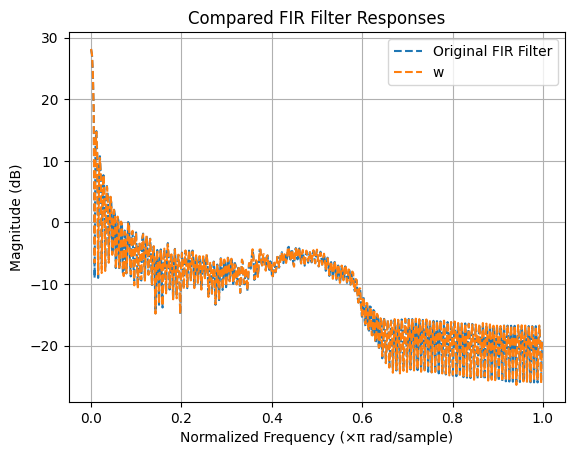

In [9]:
# Frequency response of the optimized IIR filter
freq, response_ = freqz(ir, 1)

# Plotting the responses
plt.plot(freq / np.pi, 20 * np.log10(abs(response_)), label='Original FIR Filter', linestyle='--')

freq, response_ = freqz(w, 1)

# Plotting the responses
plt.plot(freq / np.pi, 20 * np.log10(abs(response_)), label='w', linestyle='--')
plt.title('Compared FIR Filter Responses')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True)
plt.show()


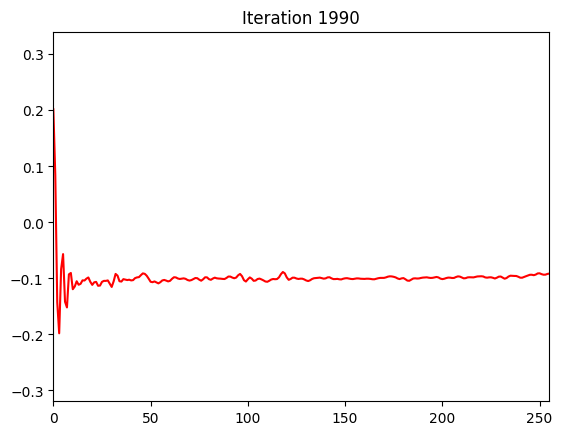

In [12]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML, display
def Nlms_filter(x, d, N, mu):
    w, buf = np.zeros(N), np.zeros(N)
    y, err = [], []
    W = np.zeros((len(x), N))  # For storing w at each iteration

    for n in range(len(x)):
        out, buf = processor.fir_convolution(x[n], w, buf)
        e = d[n] - out
        norm_factor = np.dot(buf, buf) + 1e-8
        w += (mu * e * buf) / norm_factor
        W[n, :] = w  # Save the filter coefficients after update
        err.append(e)
        y.append(out)

    return y, err, W

# Example usage:
x = np.random.randn(10000) * 0.1
d = np.convolve(x, ir)  # Example impulse response
N = 256
mu = 0.7
frames = len(x)

y, err, W = Nlms_filter(x, d, N, mu)


# Plotting
fig, ax = plt.subplots()
line, = ax.plot(W[0, :], 'r-')
ax.set_xlim(0, N-1)
ax.set_ylim(np.min(W)-0.1, np.max(W)+0.1)

def update(frame):
    line.set_ydata(W[frame*10, :])
    ax.set_title(f'Iteration {frame*10}')
    return line,

ani = FuncAnimation(fig, update, frames=200, blit=True)
rc('animation',html='jshtml')
ani